/tmp/ipykernel_80909/3499025065.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapped_df['color'] = mapped_df['agreement_class'].map(agreement_color_map).fillna('black')


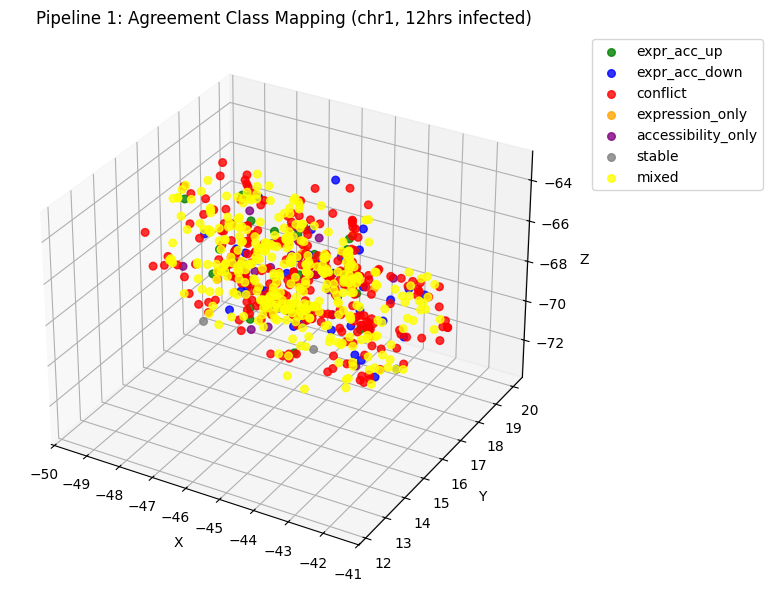

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load data
temporal_df = pd.read_csv("data/green_monkey/all_structure_files/chr1/temporal_data/chr1_temporal_trendCategories_valuePattern_curveFeatures.csv")
structure_df = pd.read_csv("data/green_monkey/all_structure_files/chr1/12hrs/vacv/structure_12hrs_vacv_gene_info.csv")

# Keep only needed columns from temporal data
temporal_subset = temporal_df[['gene_name', 'agreement_class']]

# Merge with structure coordinates for matching genes
merged_df = pd.merge(structure_df, temporal_subset, on='gene_name', how='inner')

# Prepare data for mapping
mapped_df = merged_df[['gene_name', 'middle_x', 'middle_y', 'middle_z', 'agreement_class']]

# Define color mapping for agreement classes
agreement_color_map = {
    'expr_acc_up': 'green',
    'expr_acc_down': 'blue',
    'conflict': 'red',
    'expression_only': 'orange',
    'accessibility_only': 'purple',
    'stable': 'gray',
    'mixed': 'yellow'
}

mapped_df['color'] = mapped_df['agreement_class'].map(agreement_color_map).fillna('black')

# Plot static 3D scatter
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for cls, color in agreement_color_map.items():
    subset = mapped_df[mapped_df['agreement_class'] == cls]
    ax.scatter(subset['middle_x'], subset['middle_y'], subset['middle_z'],
               c=color, label=cls, s=30, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Pipeline 1: Agreement Class Mapping (chr1, 12hrs infected)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
import trimesh
import numpy as np

# Load the mesh from OBJ
mesh = trimesh.load("data/green_monkey/all_structure_files/chr1/spatial_data/overall_shapes/chr1_12hrs_vacv_metaball.obj")

# Extract vertices
vertices = np.array(mesh.vertices)

# Gene coordinates and agreement class mapped_df
gene_coords = mapped_df[['middle_x', 'middle_y', 'middle_z']].values
gene_classes = mapped_df['agreement_class'].values

# Map agreement classes to colors (RGB)
color_map_rgb = {
    'expr_acc_up': (0, 255, 0),       # green
    'expr_acc_down': (0, 0, 255),     # blue
    'conflict': (255, 0, 0),          # red
    'expression_only': (255, 165, 0), # orange
    'accessibility_only': (128, 0, 128), # purple
    'stable': (128, 128, 128),        # gray
    'mixed': (255, 255, 0),           # yellow
}

# Assign nearest gene to each mesh vertex
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1).fit(gene_coords)
distances, indices = nn.kneighbors(vertices)

# Map vertices to gene agreement class
vertex_classes = gene_classes[indices[:, 0]]

# Convert classes to RGB colors
vertex_colors = np.array([color_map_rgb.get(cls, (0, 0, 0)) for cls in vertex_classes], dtype=np.uint8)

# Add vertex colors to the mesh
mesh.visual.vertex_colors = vertex_colors

# Export the colored mesh to a new OBJ for viewing
output_path = "data/green_monkey/all_structure_files/chr1/spatial_data/agreement_class/aachr1_12hrs_vacv_agreement_class_colored.obj"
mesh.export(output_path)

output_path


'data/green_monkey/all_structure_files/chr1/spatial_data/agreement_class/aachr1_12hrs_vacv_agreement_class_colored.obj'

In [7]:
import trimesh

# Load the colored mesh
mesh = trimesh.load("data/green_monkey/all_structure_files/chr1/spatial_data/agreement_class/aachr1_12hrs_vacv_agreement_class_colored.obj")
print(mesh.vertices.shape, mesh.faces.shape)
print(mesh.is_watertight, mesh.is_winding_consistent)

# Create a scene
scene = trimesh.Scene(mesh)

# Show in JupyterLab (interactive WebGL)
scene.show()


(15262, 3) (30536, 3)
True True


In [8]:
# Show basic info
merged_preview = merged_df[['gene_name', 'middle_x', 'middle_y', 'middle_z', 'agreement_class']].head()
merged_count = len(merged_df)

merged_preview, merged_count

(  gene_name   middle_x   middle_y   middle_z     agreement_class
 0     BET1L -43.838707  14.244620 -66.835629            conflict
 1     RIC8A -43.880255  14.211091 -66.794623               mixed
 2     SIRT3 -44.024084  14.095021 -66.652669               mixed
 3    PSMD13 -44.130924  14.008801 -66.547223            conflict
 4     NLRP6 -44.325496  13.851781 -66.355188  accessibility_only,
 802)

In [6]:
import os
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from skimage.measure import marching_cubes
import trimesh
from sklearn.neighbors import NearestNeighbors

# Load merged data (structure + agreement)
df = merged_df.copy()

# Estimate radius using nearest neighbor distance
def estimate_radius_nnd(points, scale=1.5):
    nbrs = NearestNeighbors(n_neighbors=2).fit(points)
    distances, _ = nbrs.kneighbors(points)
    avg_dist = np.mean(distances[:, 1])
    return avg_dist * scale

# Create scalar field via metaball union 
def create_metaball_field(points, grid_resolution=100, radius=5.0, grid_margin=10):
    mins = points.min(axis=0) - grid_margin
    maxs = points.max(axis=0) + grid_margin
    dims = (maxs - mins)
    spacing = dims / grid_resolution

    x = np.linspace(mins[0], maxs[0], grid_resolution)
    y = np.linspace(mins[1], maxs[1], grid_resolution)
    z = np.linspace(mins[2], maxs[2], grid_resolution)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    field = np.zeros_like(X)

    for p in points:
        d2 = (X - p[0])**2 + (Y - p[1])**2 + (Z - p[2])**2
        field += np.exp(-d2 / (2 * radius**2))

    return field, (x, y, z)

# Automatically detect marching cube level 
def auto_select_level(field, grid_axes, level_range=(0.3, 0.7), steps=10):
    best_level = None
    best_score = -np.inf
    levels = np.linspace(level_range[0], level_range[1], steps)

    for lvl in levels:
        try:
            verts, faces, _, _ = marching_cubes(field, level=lvl)
            surface_area = trimesh.Trimesh(vertices=verts, faces=faces).area
            score = -abs(surface_area - 10000)  # target surface area
            if score > best_score:
                best_score = score
                best_level = lvl
        except Exception:
            continue

    return best_level

# Extract surface from scalar field
def extract_metaball_surface(field, grid_axes, level=0.5):
    verts, faces, _, _ = marching_cubes(field, level=level)
    x, y, z = grid_axes
    spacing = [(a[1] - a[0]) for a in grid_axes]
    origin = [a[0] for a in grid_axes]
    verts_world = verts * spacing + origin
    return trimesh.Trimesh(vertices=verts_world, faces=faces, process=False)

# Run Localized Metaball Pipeline 
def run_local_metaball_pipeline_per_class(merged_df, out_dir, resolution=100):
    os.makedirs(out_dir, exist_ok=True)
    exported = []

    for cls in merged_df['agreement_class'].unique():
        points = merged_df[merged_df['agreement_class'] == cls][['middle_x', 'middle_y', 'middle_z']].dropna().values
        if len(points) < 4:
            continue

        print(f"Processing '{cls}' with {len(points)} points...")

        radius = estimate_radius_nnd(points, scale=1.5)
        field, axes = create_metaball_field(points, grid_resolution=resolution, radius=radius)
        level = auto_select_level(field, axes)
        print(f" → Radius: {radius:.2f}, Level: {level}")

        mesh = extract_metaball_surface(field, axes, level=level)

        out_path = os.path.join(out_dir, f"{cls.replace(' ', '_')}_local.obj")
        mesh.export(out_path)
        exported.append(out_path)

        print(f" → Saved: {out_path}")

    return exported

# usage
# merged_df should already contain ['middle_x', 'middle_y', 'middle_z', 'agreement_class']
output_dir = "data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local"
exported_files = run_local_metaball_pipeline_per_class(df, output_dir, resolution=100)


Processing 'conflict' with 309 points...
 → Radius: 0.55, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/conflict_local.obj
Processing 'mixed' with 367 points...
 → Radius: 0.53, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/mixed_local.obj
Processing 'accessibility_only' with 25 points...
 → Radius: 1.61, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/accessibility_only_local.obj
Processing 'expr_acc_down' with 58 points...
 → Radius: 1.14, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/expr_acc_down_local.obj
Processing 'expr_acc_up' with 33 points...
 → Radius: 1.50, Level: 0.3
 → Saved: data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local/expr_acc_up_local.obj
Processing 'expression_only' with 8 points...
 → Radi

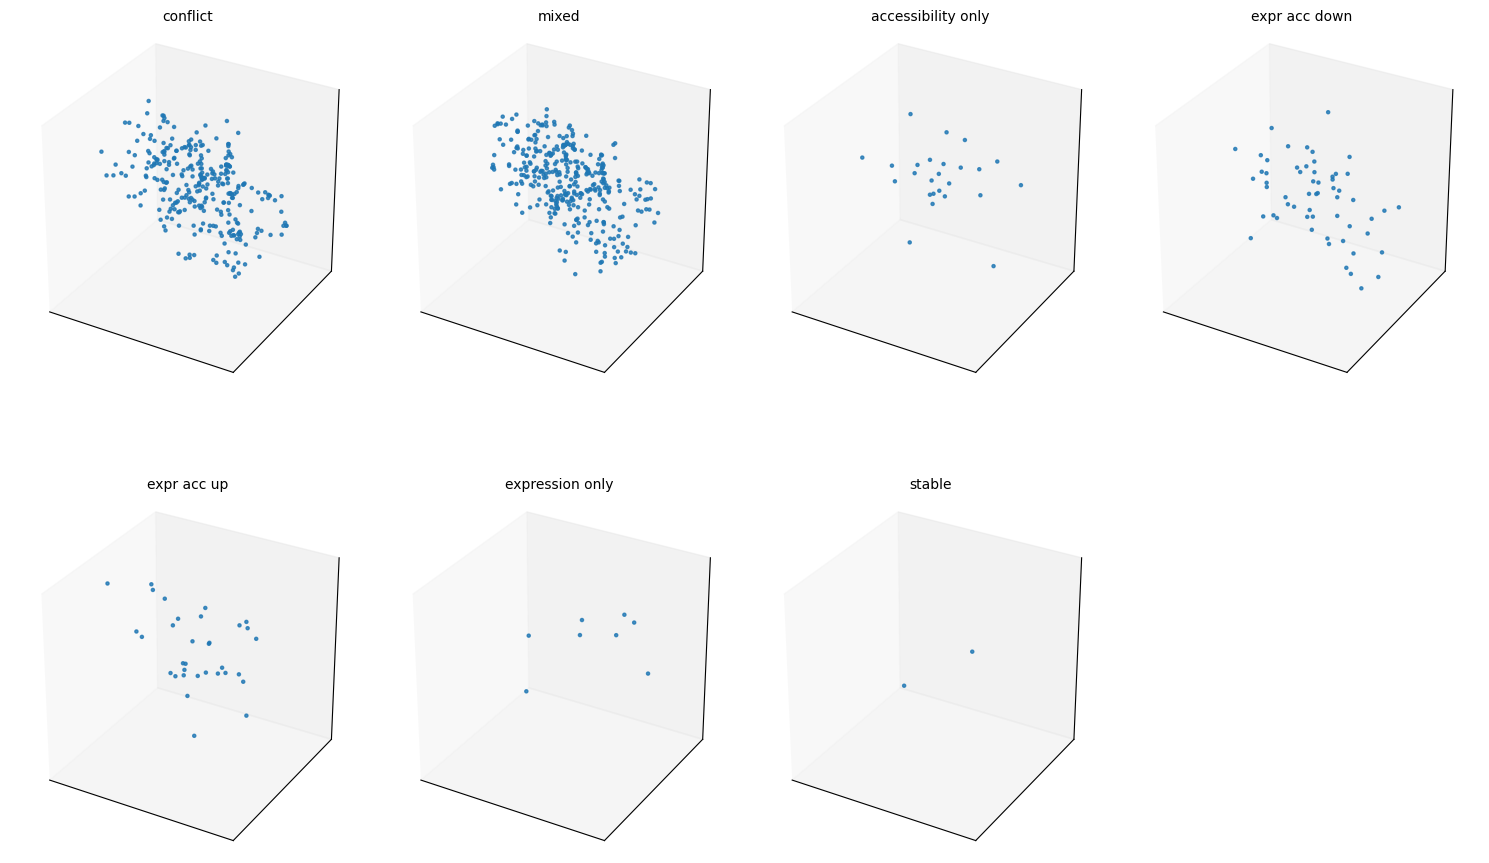

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# Columns
x_col = "middle_x"
y_col = "middle_y"
z_col = "middle_z"
group_col = "agreement_class"

# Unique agreement categories
agreement_classes = merged_df[group_col].dropna().unique()

# Create subplot grid
fig = plt.figure(figsize=(15, 10))
rows = 2
cols = int((len(agreement_classes) + 1) / 2)

for idx, cls in enumerate(agreement_classes):
    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    subset = merged_df[merged_df[group_col] == cls]

    ax.scatter(subset[x_col], subset[y_col], subset[z_col], s=5, alpha=0.8)
    ax.set_title(cls.replace("_", " "), fontsize=10)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()


In [11]:
import trimesh
import pyrender
import os

# Path to folder containing the OBJ files
base_path = "data/green_monkey/all_structure_files/chr1/spatial_data/output_meshes_agreement_local"  

# Agreement categories
agreement_classes = [
    "conflict",
    "expression_only",
    "accessibility_only",
    "expr_acc_up",
    "expr_acc_down",
    "mixed"
]

# Color map
class_colors = {
    "conflict": [1.0, 0.2, 0.2],
    "expression_only": [0.2, 0.9, 0.2],
    "accessibility_only": [0.6, 0.2, 1.0],
    "expr_acc_up": [1.0, 0.5, 0.1],
    "expr_acc_down": [0.2, 0.9, 0.9],
    "mixed": [0.2, 0.5, 1.0]
}

# Create a scene
scene = pyrender.Scene(bg_color=[0, 0, 0, 1])

for i, cls in enumerate(agreement_classes):
    file_path = os.path.join(base_path, f"{cls}_local.obj")
    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        continue

    mesh = trimesh.load(file_path, force="mesh")
    color = class_colors.get(cls, [0.5, 0.5, 0.5])

    # Apply uniform color to all vertices
    mesh.visual.vertex_colors = [int(c * 255) for c in color]

    # Convert to pyrender mesh
    render_mesh = pyrender.Mesh.from_trimesh(mesh)

    # Position in a grid
    x = (i % 3) * 60 - 60  # e.g., -60, 0, 60
    y = -(i // 3) * 60     # e.g., 0, -60
    node = pyrender.Node(mesh=render_mesh, translation=[x, y, 0])
    scene.add_node(node)

# Launch viewer
viewer = pyrender.Viewer(scene, use_raymond_lighting=True, run_in_thread=False)
